# Metodos de separación ciega de señales aplicado a videos

Se exploran los metodos:
        
    - FCA fast sobre una imagen obtenida de samplear valores de los pixeles en el video (se intentan 3 tamaños)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
import scipy.linalg 
from scipy.optimize import minimize

In [2]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, parent_dir)

from BSS import FCA_fast, OVFCA_fast, unmixing_error

In [3]:
from funciones_auxiliares import read_video_frames_and_format, transform_frames_2_grayscale, process_frames_video, mezclar_videos, concatenate_videos, procesar_videos_color, procesar_video_color, obtener_imagen_con_valores_video 

In [4]:
folder_videos = "../Videos_originales/"

video1_path = folder_videos + "v1.mp4"
video2_path = folder_videos + "v2.mp4"
video3_path = folder_videos + "v3.mp4"

N = 100
frame_size = (N, N)
number_of_frames = 100
number_of_frames = 603

# Leer videos

In [5]:
# read videos with same same and number of frames
video1_frames_color = read_video_frames_and_format(video1_path, size = frame_size, target_frames = number_of_frames)
video2_frames_color = read_video_frames_and_format(video2_path, size = frame_size, target_frames = number_of_frames)
video3_frames_color = read_video_frames_and_format(video3_path, size = frame_size, target_frames = number_of_frames)
# sample the video 4  (uniform distribution)
noise = np.random.randint(0, 256, video1_frames_color.shape[:-1], dtype=np.uint8)
noise_3 = np.array([noise, noise, noise])
video4_frames_color = np.transpose(noise_3, (1, 2, 3, 0))
print(f"Shape of noise video: {video4_frames_color.shape}")

Original video:
Total number of frames: 603
Frame shape: (720, 720)

New frames shape: (603, 100, 100, 3)
--------------------------------------------------
Original video:
Total number of frames: 603
Frame shape: (720, 720)

New frames shape: (603, 100, 100, 3)
--------------------------------------------------
Original video:
Total number of frames: 603
Frame shape: (720, 720)

New frames shape: (603, 100, 100, 3)
--------------------------------------------------
Shape of noise video: (603, 100, 100, 3)


In [6]:
# transform the videos to grayscale
video1_frames = transform_frames_2_grayscale(video1_frames_color)
video2_frames = transform_frames_2_grayscale(video2_frames_color)
video3_frames = transform_frames_2_grayscale(video3_frames_color)
video4_frames = transform_frames_2_grayscale(video4_frames_color)

Original shape: (603, 100, 100, 3)
Grayscale shape: (603, 100, 100)
--------------------------------------------------
Original shape: (603, 100, 100, 3)
Grayscale shape: (603, 100, 100)
--------------------------------------------------
Original shape: (603, 100, 100, 3)
Grayscale shape: (603, 100, 100)
--------------------------------------------------
Original shape: (603, 100, 100, 3)
Grayscale shape: (603, 100, 100)
--------------------------------------------------


In [7]:
# process (mean and variance)
video1_frames_processed = process_frames_video(video1_frames)
video2_frames_processed = process_frames_video(video2_frames)
video3_frames_processed = process_frames_video(video3_frames)
video4_frames_processed = process_frames_video(video4_frames)

In [8]:
# juntar distintdas versiones de los 4 videos
# cada uno es de la forma: (num_videos, num_frames_video, N, N, color_chanels)
videos_color = np.array([video1_frames_color, video2_frames_color, video3_frames_color, video4_frames_color])
videos = np.array([video1_frames, video2_frames, video3_frames, video4_frames])
videos_processed = np.array([video1_frames_processed, video2_frames_processed, video3_frames_processed, video4_frames_processed])

# ver formar
print(f"Shape videos (color): {videos_color.shape}")
print(f"Shape videos: {videos.shape}")
print(f"Shape videos (processed): {videos_processed.shape}")

Shape videos (color): (4, 603, 100, 100, 3)
Shape videos: (4, 603, 100, 100)
Shape videos (processed): (4, 603, 100, 100)


# Mix the videos

In [9]:
# delimitar matriz de mezcla
A = [[0.4, 0.65, -0.4, -0.8], [0.4, 0.4, -0.4, 0.9], [-0.4, -0.4, 0.6, 0.8], [0.7, 0.5, -0.5, -0.8]]
A = np.array(A)
A

array([[ 0.4 ,  0.65, -0.4 , -0.8 ],
       [ 0.4 ,  0.4 , -0.4 ,  0.9 ],
       [-0.4 , -0.4 ,  0.6 ,  0.8 ],
       [ 0.7 ,  0.5 , -0.5 , -0.8 ]])

In [10]:
# mezclar los videos en los distintos formatos
videos_color_mezcla = mezclar_videos(A, videos_color)
videos_mezcla = mezclar_videos(A, videos)
videos_processed_mezcla = mezclar_videos(A, videos_processed)

Shape original: (4, 603, 100, 100, 3)
Shape mixture: (4, 603, 100, 100, 3)
----------------------------------------
Shape original: (4, 603, 100, 100)
Shape mixture: (4, 603, 100, 100)
----------------------------------------
Shape original: (4, 603, 100, 100)
Shape mixture: (4, 603, 100, 100)
----------------------------------------


# Intentar estimar la matriz de mezcla


### Separar usando un solo frame sampleando distintos pixeles de todo el video

### Intentar varias opciones con distinto numero de valores sampleados

### FCA - tamaño 1

In [11]:
# dimensiones de las imagenes a crear con los valores sampleados
N_imagen = 100

In [12]:
# samplear los valores a sacar a traves del video

# ver cuantos valores se samplean
num_valores_samplear = N_imagen * N_imagen 
# primero samplear los pixeles, despues los frames, juntar todo
pixeles_sampleados = np.random.randint(0, N, size=(num_valores_samplear, 2))
frames_sampleados = np.random.randint(0, number_of_frames, size=(num_valores_samplear, 1))
indices_sampleados = np.hstack((frames_sampleados, pixeles_sampleados))
print(f"Shape indices: {indices_sampleados.shape}")

Shape indices: (10000, 3)


In [13]:
# frames con pre-procesamiento

# obtener las señales originales (solo por visualizacion)
frame_x1_processed = obtener_imagen_con_valores_video(videos_processed[0], indices_sampleados, N_imagen)
frame_x2_processed = obtener_imagen_con_valores_video(videos_processed[1], indices_sampleados, N_imagen)
frame_x3_processed = obtener_imagen_con_valores_video(videos_processed[2], indices_sampleados, N_imagen)
frame_x4_processed = obtener_imagen_con_valores_video(videos_processed[3], indices_sampleados, N_imagen)
señales_originales_x_processed = [frame_x1_processed, frame_x2_processed, frame_x3_processed, frame_x4_processed]

# obtener las señales mezcladas (para aplicar fca)
frame_y1_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[0], indices_sampleados, N_imagen)
frame_y2_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[1], indices_sampleados, N_imagen)
frame_y3_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[2], indices_sampleados, N_imagen)
frame_y4_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[3], indices_sampleados, N_imagen)
señales_y_processed = [frame_y1_processed, frame_y2_processed, frame_y3_processed, frame_y4_processed]

In [14]:
start_time = time.time()

# ejecutar FCA
fca = FCA_fast(señales_y_processed)
fca.separar_señaes(repeticiones_optimizacion = 1, iniciar_W_ortogonal = True)
elapsed_time = time.time() - start_time

print(f"Ejecucion duro {elapsed_time} segundos")

Ejecucion duro 4.319009304046631 segundos


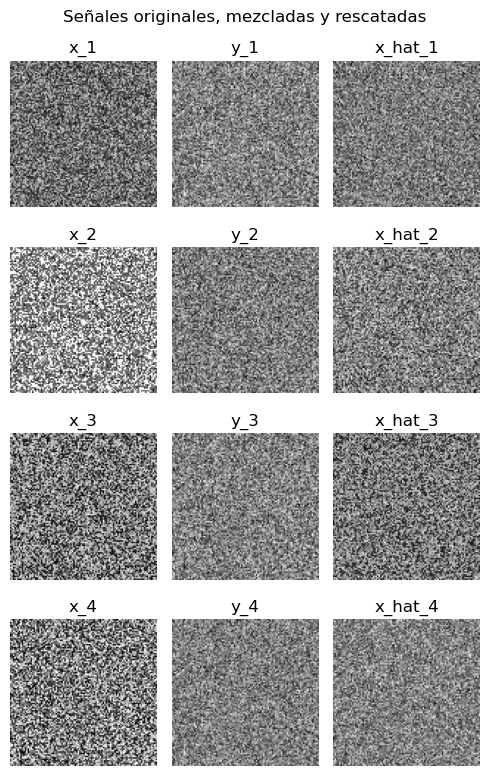

In [15]:
# ver el resultado
fca.ver(señales_x_originales = señales_originales_x_processed, figsize = (5, 8))

In [16]:
# salvar la matriz estimada por este metodo
A_hat_fca_1 = fca.A_hat
A_hat_inv_fca_1 = fca.A_hat_inversa

### FCA - tamaño 2

In [17]:
# dimensiones de las imagenes a crear con los valores sampleados
N_imagen = 200

In [18]:
# samplear los valores a sacar a traves del video

# ver cuantos valores se samplean
num_valores_samplear = N_imagen * N_imagen 
# primero samplear los pixeles, despues los frames, juntar todo
pixeles_sampleados = np.random.randint(0, N, size=(num_valores_samplear, 2))
frames_sampleados = np.random.randint(0, number_of_frames, size=(num_valores_samplear, 1))
indices_sampleados = np.hstack((frames_sampleados, pixeles_sampleados))
print(f"Shape indices: {indices_sampleados.shape}")

Shape indices: (40000, 3)


In [19]:
# frames con pre-procesamiento

# obtener las señales originales (solo por visualizacion)
frame_x1_processed = obtener_imagen_con_valores_video(videos_processed[0], indices_sampleados, N_imagen)
frame_x2_processed = obtener_imagen_con_valores_video(videos_processed[1], indices_sampleados, N_imagen)
frame_x3_processed = obtener_imagen_con_valores_video(videos_processed[2], indices_sampleados, N_imagen)
frame_x4_processed = obtener_imagen_con_valores_video(videos_processed[3], indices_sampleados, N_imagen)
señales_originales_x_processed = [frame_x1_processed, frame_x2_processed, frame_x3_processed, frame_x4_processed]

# obtener las señales mezcladas (para aplicar fca)
frame_y1_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[0], indices_sampleados, N_imagen)
frame_y2_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[1], indices_sampleados, N_imagen)
frame_y3_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[2], indices_sampleados, N_imagen)
frame_y4_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[3], indices_sampleados, N_imagen)
señales_y_processed = [frame_y1_processed, frame_y2_processed, frame_y3_processed, frame_y4_processed]

In [20]:
start_time = time.time()

# ejecutar FCA
fca = FCA_fast(señales_y_processed)
fca.separar_señaes(repeticiones_optimizacion = 1, iniciar_W_ortogonal = True)
elapsed_time = time.time() - start_time

print(f"Ejecucion duro {elapsed_time} segundos")

Ejecucion duro 12.806745767593384 segundos


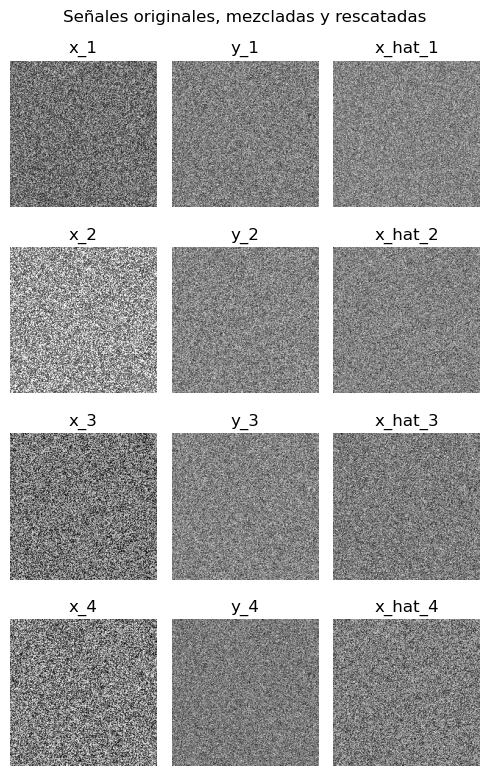

In [21]:
# ver el resultado
fca.ver(señales_x_originales = señales_originales_x_processed, figsize = (5, 8))

In [22]:
# salvar la matriz estimada por este metodo
A_hat_fca_2 = fca.A_hat
A_hat_inv_fca_2 = fca.A_hat_inversa

### FCA - tamaño 3

In [23]:
# dimensiones de las imagenes a crear con los valores sampleados
N_imagen = 300

In [24]:
# samplear los valores a sacar a traves del video

# ver cuantos valores se samplean
num_valores_samplear = N_imagen * N_imagen 
# primero samplear los pixeles, despues los frames, juntar todo
pixeles_sampleados = np.random.randint(0, N, size=(num_valores_samplear, 2))
frames_sampleados = np.random.randint(0, number_of_frames, size=(num_valores_samplear, 1))
indices_sampleados = np.hstack((frames_sampleados, pixeles_sampleados))
print(f"Shape indices: {indices_sampleados.shape}")

Shape indices: (90000, 3)


In [25]:
# frames con pre-procesamiento

# obtener las señales originales (solo por visualizacion)
frame_x1_processed = obtener_imagen_con_valores_video(videos_processed[0], indices_sampleados, N_imagen)
frame_x2_processed = obtener_imagen_con_valores_video(videos_processed[1], indices_sampleados, N_imagen)
frame_x3_processed = obtener_imagen_con_valores_video(videos_processed[2], indices_sampleados, N_imagen)
frame_x4_processed = obtener_imagen_con_valores_video(videos_processed[3], indices_sampleados, N_imagen)
señales_originales_x_processed = [frame_x1_processed, frame_x2_processed, frame_x3_processed, frame_x4_processed]

# obtener las señales mezcladas (para aplicar fca)
frame_y1_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[0], indices_sampleados, N_imagen)
frame_y2_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[1], indices_sampleados, N_imagen)
frame_y3_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[2], indices_sampleados, N_imagen)
frame_y4_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[3], indices_sampleados, N_imagen)
señales_y_processed = [frame_y1_processed, frame_y2_processed, frame_y3_processed, frame_y4_processed]

In [26]:
start_time = time.time()

# ejecutar FCA
fca = FCA_fast(señales_y_processed)
fca.separar_señaes(repeticiones_optimizacion = 1, iniciar_W_ortogonal = True)
elapsed_time = time.time() - start_time

print(f"Ejecucion duro {elapsed_time} segundos")

Ejecucion duro 230.99778747558594 segundos


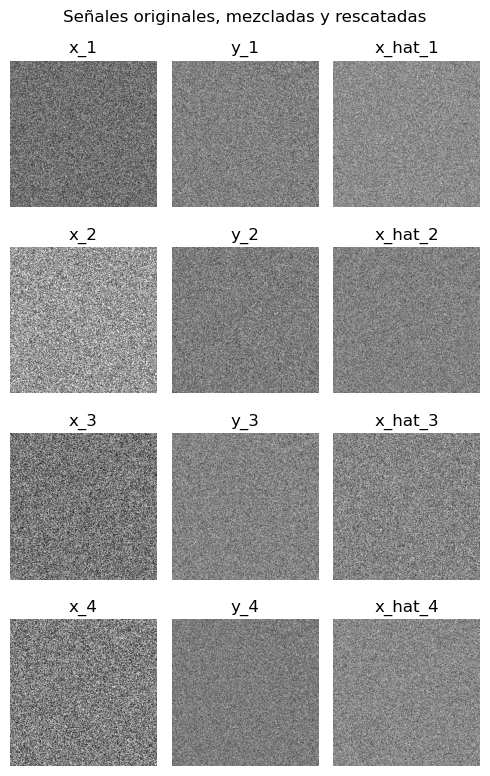

In [27]:
# ver el resultado
fca.ver(señales_x_originales = señales_originales_x_processed, figsize = (5, 8))

In [28]:
# salvar la matriz estimada por este metodo
A_hat_fca_3 = fca.A_hat
A_hat_inv_fca_3 = fca.A_hat_inversa

# Hacer la separacion del video a color

In [29]:
# obtener estimaciones de las señales originales
videos_color_hat_fca_1 = mezclar_videos(A_hat_inv_fca_1, videos_color_mezcla)
videos_color_hat_fca_2 = mezclar_videos(A_hat_inv_fca_2, videos_color_mezcla)
videos_color_hat_fca_3 = mezclar_videos(A_hat_inv_fca_3, videos_color_mezcla)

Shape original: (4, 603, 100, 100, 3)
Shape mixture: (4, 603, 100, 100, 3)
----------------------------------------
Shape original: (4, 603, 100, 100, 3)
Shape mixture: (4, 603, 100, 100, 3)
----------------------------------------
Shape original: (4, 603, 100, 100, 3)
Shape mixture: (4, 603, 100, 100, 3)
----------------------------------------


In [30]:
# CAMBIOS DE SIGNOS MANUALES, PARA MEJOR VISUALIZACION

videos_color_hat_fca_1[0] *= -1
videos_color_hat_fca_1[1] *= -1
videos_color_hat_fca_1[2] *= -1
videos_color_hat_fca_1[3] *= -1

videos_color_hat_fca_2[0] *= -1
videos_color_hat_fca_2[1] *= -1
videos_color_hat_fca_2[2] *= -1
videos_color_hat_fca_2[3] *= -1

videos_color_hat_fca_3[0] *= -1
videos_color_hat_fca_3[1] *= -1
videos_color_hat_fca_3[2] *= -1
videos_color_hat_fca_3[3] *= -1

In [31]:
# procesar videos para que se puedan ver correctamente
videos_color_mezcla_rgb = procesar_videos_color(videos_color_mezcla)
videos_color_hat_fca_1_rgb = procesar_videos_color(videos_color_hat_fca_1)
videos_color_hat_fca_2_rgb = procesar_videos_color(videos_color_hat_fca_2)
videos_color_hat_fca_3_rgb = procesar_videos_color(videos_color_hat_fca_3)

In [32]:
# hacer el video para fca_single
lista_videos_hat_fca_1 = [videos_color, videos_color_mezcla_rgb, videos_color_hat_fca_1_rgb]
concatenate_videos(lista_videos_hat_fca_1, output_path = "../Videos_output/fca_sample_small.mp4")

Video guardado en ../Videos_output/fca_sample_small.mp4


In [33]:
# hacer el video para fca_single
lista_videos_hat_fca_2 = [videos_color, videos_color_mezcla_rgb, videos_color_hat_fca_2_rgb]
concatenate_videos(lista_videos_hat_fca_2, output_path = "../Videos_output/fca_sample_medium.mp4")

Video guardado en ../Videos_output/fca_sample_medium.mp4


In [34]:
# hacer el video para fca_single
lista_videos_hat_fca_3 = [videos_color, videos_color_mezcla_rgb, videos_color_hat_fca_3_rgb]
concatenate_videos(lista_videos_hat_fca_3, output_path = "../Videos_output/fca_sample_large.mp4")

Video guardado en ../Videos_output/fca_sample_large.mp4


# Evaluar el error de cada metodo



In [35]:
# ver los errores de los metodos considerados
error_fca_1 = unmixing_error(A, A_hat_fca_1)
error_fca_2 = unmixing_error(A, A_hat_fca_2)
error_fca_3 = unmixing_error(A, A_hat_fca_3)

In [36]:
# mostrar
decimales = 3
print(f"Error FCA sample small: {round(error_fca_1, decimales)}")
print(f"Error FCA sample medium: {round(error_fca_2, decimales)}")
print(f"Error FCA sample large: {round(error_fca_3, decimales)}")

Error FCA sample small: 1.17
Error FCA sample medium: 1.425
Error FCA sample large: 1.371
